# Case Study 10: Missing Variables 
## Team : Samuel Arellano, Daniel Clark, Dhyan Shah, Chandler Vaugh

In [1]:
# Import package dependencies
import pandas as pd
import numpy as np

import scipy.stats as stats
import statsmodels.api as sm

import sklearn
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from math import sqrt


import altair as alt
from ml_metrics import rmse

# Abstract

# Introduction

While in an ideal world all datasets would be complete, in the real world datasets often have some missing data fields. There are countless reasons for the the existence of missing data but for the most part missing data falls into one of three categories:

* Missing completely at random (MCAR) - No reason why, totally random. 

* Missing at random (MAR) - Typically missing only in a subset of data – the subset of data is determined by   another value, but within the subset the data is randomly missing. 

* Not missing at random (NMAR) - There is a definite pattern to the missing data.

In the case of MCAR and and MAR, deletion of the missing values through listwise or pairwise methods can be employed, however this can present some problems. In the case of listwise deletion the resulting data set will be smaller a reduce the power of statistical tests, deletion of too many records may lead to an inaccurate representation of the data, and if the missing data is MNAR deletion of the records may obscure the presence of a systematic problem and result in biased results. In the case of pairwise deletion, the resulting dataset can lead to parameters based on different standard errors, result in measures of mean and standard for fields with a different number of observations, affect the sample sizes used for calculating correlation. All these issues can create computational problems for certain statistical analysis methods. One alternative to the deletion of missing values is assigning a value to the missing fields through imputation. However as with deletion, imputation can affect the characteristics of the dataset and bias the results of statistical computations. 

This project will evaluate the efficacy of deletion and imputation as solutions to missing data. We will use a complete data set, the Boston Housing dataset, to test various methods and determine the method that results in a model that best captures the characteristics of the original dataset. We will accomplish this by first fitting a linear model to the full Boston housing dataset and calculating the goodness of fit for the model parameters, that will act as our baseline and control. We will then create 6 new datasets by randomly removing 1%, 5%, 10%, 20%, 33% and 50% of the observations in a single column from the full dataset. We will then then fit each of the missing value datasets using pairwise deletion and different imputation methods and calculate the goodness of fit for each method of dealing with missing data for each level of missing data to determine the efficacy of each method given each condition.

# Data

The Boston Housing dataset is compiled dataset derived from U.S. Census service information regarding housing in  Boston area in Massachusetts. The dataset has been used extensively to test and benchmark predictive machine learning algorithms. For this study we loaded a copy of the dataset that is available as part of the sklearn package. 

In [2]:
boston = load_boston()
print(boston.data.shape)

(506, 13)


The dataset consists of 506 observations across 13 fields and was packaged in the following dictionaries: ['data', 'target', 'feature_names', 'DESCR', 'filename']. Opening the DESCR dictionary gives us detailed information regarding the data contained within the dataset along with descriptions of the predictor variables and the dependant median value attribute contained in the target dictionary.  

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In order to better manipulate the data. We constructed a pandas dataframe and  printed the first 5 observations. We then verified that there where no missing values in any of the fields before moving on to the exploratory data analysis.

In [4]:
bos_df = pd.DataFrame(boston.data)
bos_df.columns = boston.feature_names
bos_df['PRICE'] = boston.target
print(bos_df.head(), '\n')
print('NULL Values')
print(bos_df.isna().sum())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  PRICE  
0     15.3  396.90   4.98   24.0  
1     17.8  396.90   9.14   21.6  
2     17.8  392.83   4.03   34.7  
3     18.7  394.63   2.94   33.4  
4     18.7  396.90   5.33   36.2   

NULL Values
CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
PRICE      0
dtype: int64


# Exploratory Data Analysis

In [5]:
print(bos_df.describe())

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.1057

Next, we are going to run a broad exploratory of each of our 14 variables. We can see that the data is relatively normal and there aren't many cases where we can visually see if there is skewness to be concerned with. 

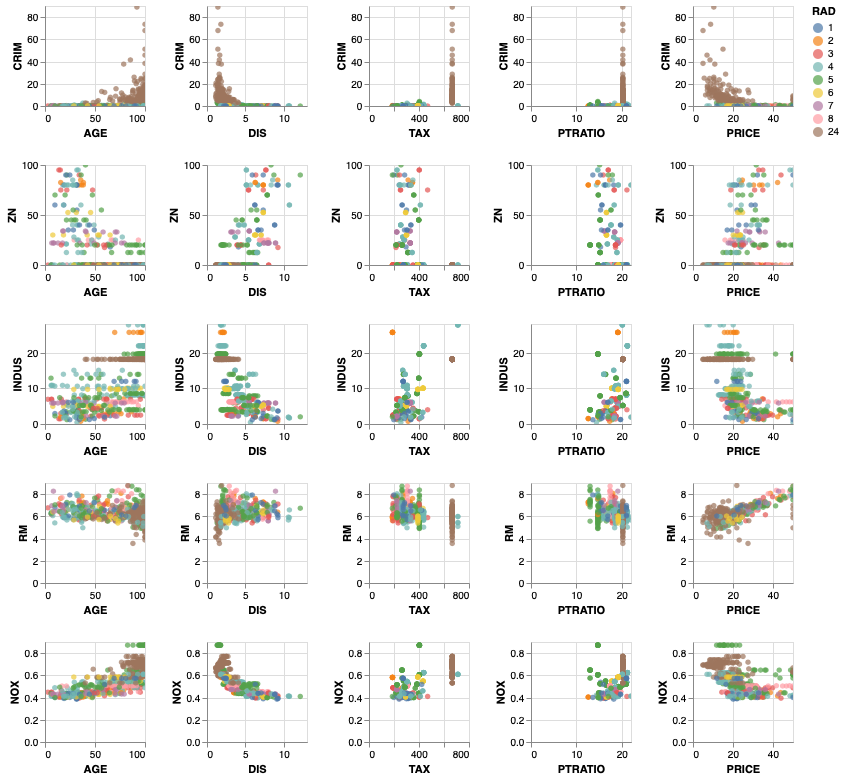

In [6]:
source = bos_df

alt.Chart(source).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='RAD:N'
).properties(
    width=100,
    height=100
).repeat(
    row=['CRIM', 'ZN', 'INDUS', 'RM', 'NOX'],
    column=['AGE', 'DIS', 'TAX', 'PTRATIO','PRICE']
).interactive()

Here we generated a series of scatter plots on 10 of the variables available, overall, there wasn't a ton of major instances of positive and negative correlations to note outside of "RM" and "PRICE", which makes sense as the average number of rooms in the house would generally correlate to the size of the home and the price. 

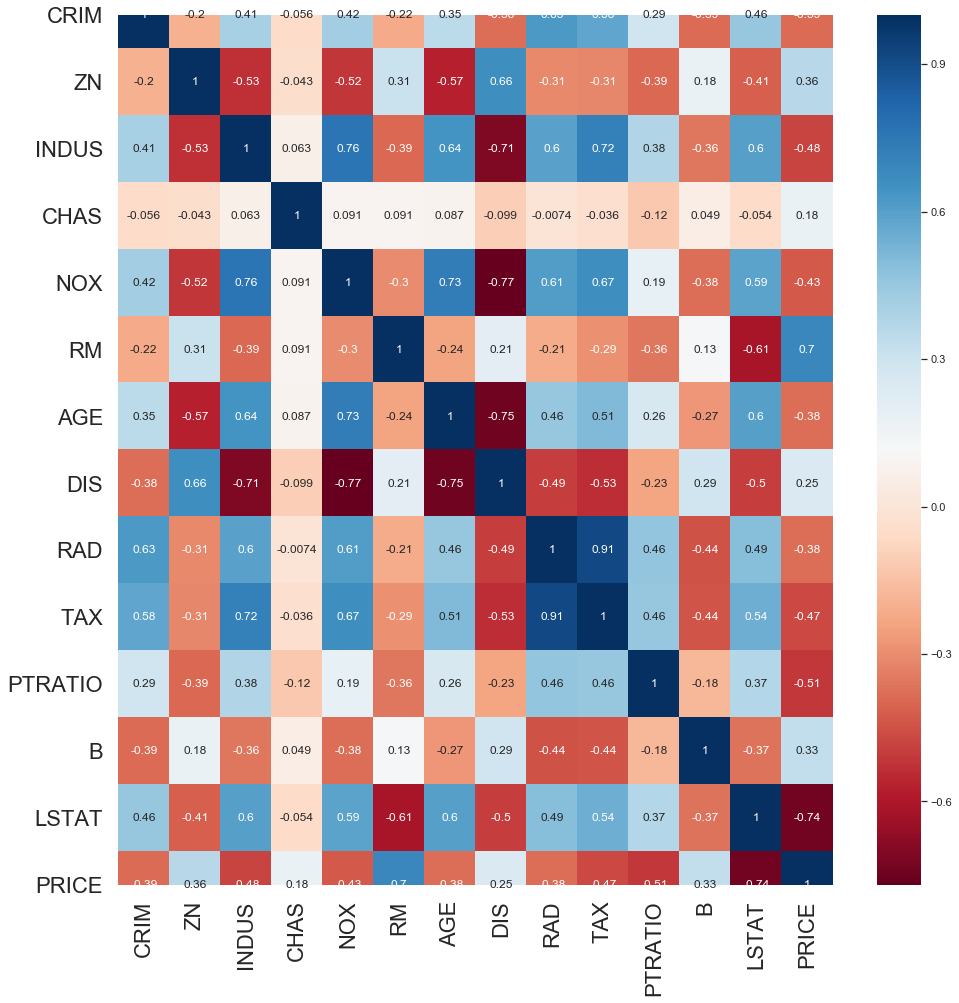

In [7]:
ax, fig = plt.subplots(figsize = (16,16))
sns.set(font_scale=1)
sns.heatmap(bos_df.corr(), annot=True, cmap = 'RdBu') 
plt.show()

Looking deeper into quantifying the correlation structure between the data points, we can see that there are some key findings to note:

* "RAD" and "TAX" have a strong positive correlation at 0.91

* "NOX and "INDUS" have a strong positive correlation at 0.76

* "AGE" and "NOX" have a strong positive correlation at 0.73

and likewise, we found strong negative correlations in the following:

* "NOX" and "DIS" have a strong negative correlation at -0.77

* "AGE" and "DIS" have a strong negative correlation at -0.75

* "LSAT" and "PRICE" have a strong negative correlation at -0.74

While typically, we would consider removing these variables when forming models for classification or regression, here, these can add valuable insight for imputation and building a baseline. 

# Fitting the Full Model
To establish our baseline linear model we first fit the full dataset using a 80/20 training and testing split.  The reason we are going to use an 80 / 20 split is to ensure we are giving our dataset a strong chance to learn from itself in order to meet the challenge of imputing lots of data with very little data available to learn from. From there, it also opens up the opportunity for 5-fold cross validation if necessary. 

Once we move into our missing data imputation, we will perform multiple procedures to imput missing data systemically, these include Missing At Random, Missing Completely at Random and Missing Not at Random. 

To evaluate these models, we will be building a baseline model and calculate our mean absolute error, mean square error, root mean square error and R2. All of which are tools to evaluate model fit and the distance the residuals have from the actual values. 

In [8]:
features = boston.feature_names

X_b = np.c_[np.ones((len(bos_df[features]),1)), bos_df[features].values] #X matrix
X_b.shape

(506, 14)

In [9]:
from sklearn.model_selection import train_test_split

X = bos_df.drop('PRICE', axis = 1)
Y = bos_df['PRICE']

X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.20, random_state = 123)

print("Training Set: ",X_train.shape)
print("Testing Set: ",X_test.shape)

Training Set:  (404, 14)
Testing Set:  (102, 14)


The training data is used to fit a linear regression model. The resulting regression had an R=squared value of .756 and an intercept of 31.83, the coefficients were normalized in order to properly assess which had the highest impact on the model.  

In [10]:
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print("R-Score: ",reg.score(X_train, Y_train))
print("Intercept: ",reg.intercept_)
print("Coefficients: ",reg.coef_)

R-Score:  0.7559380876016175
Intercept:  31.835164121206397
Coefficients:  [ 0.00000000e+00 -9.87931696e-02  4.75027102e-02  6.69491841e-02
  1.26954150e+00 -1.54697747e+01  4.31968412e+00 -9.80167937e-04
 -1.36597953e+00  2.84521838e-01 -1.27533606e-02 -9.13487599e-01
  7.22553507e-03 -5.43790245e-01]


We find that RM, average number of rooms per dwelling, is the attribute with the highest normalized coefficient. RM also had the highest positive correlation with PRICE at .70, the only attribute with a higher absolute correlation was LSTAT, % lower status of the population, at -.74 

In [11]:
print('The abs(max) coef-value is {}'.format(max(reg.coef_)))
max_var = max(reg.coef_, key=abs)
var_index = reg.coef_.tolist().index(max_var)
print('The variable associated with this coef-value is {}'.format(boston.feature_names[var_index]))

The abs(max) coef-value is 4.31968412495868
The variable associated with this coef-value is RM


We then used the fitted model and predicted against the test set. Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and R-Squared values were calculated and recorded and would serve as the baseline scores. 

In [12]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%orig_mae)
print("MSE:  %.3f"%orig_mse)
print("RMSE:  %.3f"%orig_rmse_val)
print("R2:  %.3f"%orig_r2)

MAE: 3.660
MSE:  28.192
RMSE:  5.310
R2:  0.659


These scores are all correlated with one another, and we will see them appear many times throughout the project, as a point of comparison, which we will calculate our differences.

In [13]:
res_frame = pd.DataFrame({'data':'original',
                   'imputation':'none',
                   'mae': orig_mae, 
                   'mse': orig_mse, 
                   'rmse':orig_rmse_val, 
                   'R2':orig_r2,
                   'mae_diff':np.nan,
                   'mse_diff':np.nan,
                   'rmse_diff':np.nan,
                   'R2_diff':np.nan}, index=[0])

# Missing Completely at Random (MCAR)

To test the effects of random missing data we introduced missing values to one of the variables. Though LSTAT had a slighty higher absolute correlation with PRICE we decided that because the correlation between RM and PRICE was also high, RM had a higher normalized coefficient in the model, and it is intuitively easier to understand; we would use the RM field to test the effects of missing data and imputation methods on the model. 

In [14]:
bos_na = bos_df

def insert_na(x, var):
    global bos_na
    in_sample = bos_df.sample(frac=x, random_state=123)
    in_sample[var] = np.nan
    out_sample = bos_df[~bos_df.isin(in_sample)].dropna()
    bos_na = pd.concat([in_sample, out_sample])
    return print("Null values at %.2f"%x,':' , bos_na.isnull().values.ravel().sum())

In [15]:
bos_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Six new datasets were created from the full set, each with a different percent of missing data ranging for 1% to 50%

In [16]:
insert_na(.50,"RM")
bos_na50 = bos_na
bos_na50.name = "50% deletion"
insert_na(.33,"RM")
bos_na33 = bos_na
bos_na33.name = "33% deletion"
insert_na(.20,"RM")
bos_na20 = bos_na
bos_na20.name = "20% deletion"
insert_na(.10,"RM")
bos_na10 = bos_na
bos_na10.name = "10% deletion"
insert_na(.05,"RM")
bos_na05 = bos_na
bos_na05.name = "5% deletion"
insert_na(.01,"RM")
bos_na01 = bos_na
bos_na01.name = "1% deletion"

Null values at 0.50 : 253
Null values at 0.33 : 167
Null values at 0.20 : 101
Null values at 0.10 : 51
Null values at 0.05 : 25
Null values at 0.01 : 5


## Deletion

The first approach is using the dropna() function to drop any observations that have missing values. Like the full set, the new sets were split into training and testing sets then fitted to a linear regression.

### Missing Data Completely Random

In [17]:
frames = [bos_na01, bos_na05, bos_na10, bos_na20, bos_na33, bos_na50]

for frame in frames:
    df = frame.dropna() 

    X_b = np.c_[np.ones((len(df[features]),1)), df[features].values] 
    X_b.shape

    X = df.drop('PRICE', axis = 1)
    Y = df['PRICE']

    X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.20, random_state = 123)

    reg = LinearRegression(normalize=True).fit(X_train, Y_train)

    Y_pred = reg.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print('=======================')
    print(str(frame.name))
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    print('=======================')
    
    temp_frame = pd.DataFrame({'data':frame.name,
                   'imputation':'MCAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[1])

    res_frame = pd.concat([res_frame, temp_frame])
    res_frame.reset_index(inplace=True)
    res_frame = res_frame.drop('index', axis=1)

1% deletion
MAE: 3.380
MSE:  20.406
RMSE:  4.517
R2:  0.756
5% deletion
MAE: 3.190
MSE:  27.808
RMSE:  5.273
R2:  0.686
10% deletion
MAE: 3.228
MSE:  27.419
RMSE:  5.236
R2:  0.726
20% deletion
MAE: 3.113
MSE:  19.153
RMSE:  4.376
R2:  0.795
33% deletion
MAE: 2.941
MSE:  15.563
RMSE:  3.945
R2:  0.814
50% deletion
MAE: 3.607
MSE:  24.515
RMSE:  4.951
R2:  0.583


At 1% only 5 observations are lost. Surprisingly all measures of error for the test set with the omitted values are lower and the R-squared value is higher. Though it should be pointed out that there was no cross validation used so the effect of chance on the random selection of the missing data is should not be ignored.

At 5% only 25 observations are lost. Here we begin the see the impact of the lost information, with MAE, MSE, and RMSE all higher, and R-Squared lower than the 1% missing data case. 

At 10% 51 observations for RM are lost. Metrics seem only marginally impacted, but R-Squared is again higher.

With 20%, 101 observations for RM are lost. Error rates are lower, and R-Squared higher. Much of this implies the intuitive observation that by removing RM values we have reduced overall variation in the model. 

With 33%, 167 RM observations are lost. We continue the trend of lower error rates and an increased R-Squared.

With 50% 253 observations are lost. Interestingly, we see error rates now rise markedly, and we note a severe degradation of R-Squared. 

These various iterations are summarized in the table below.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c21c00c10>,
      dtype=object)

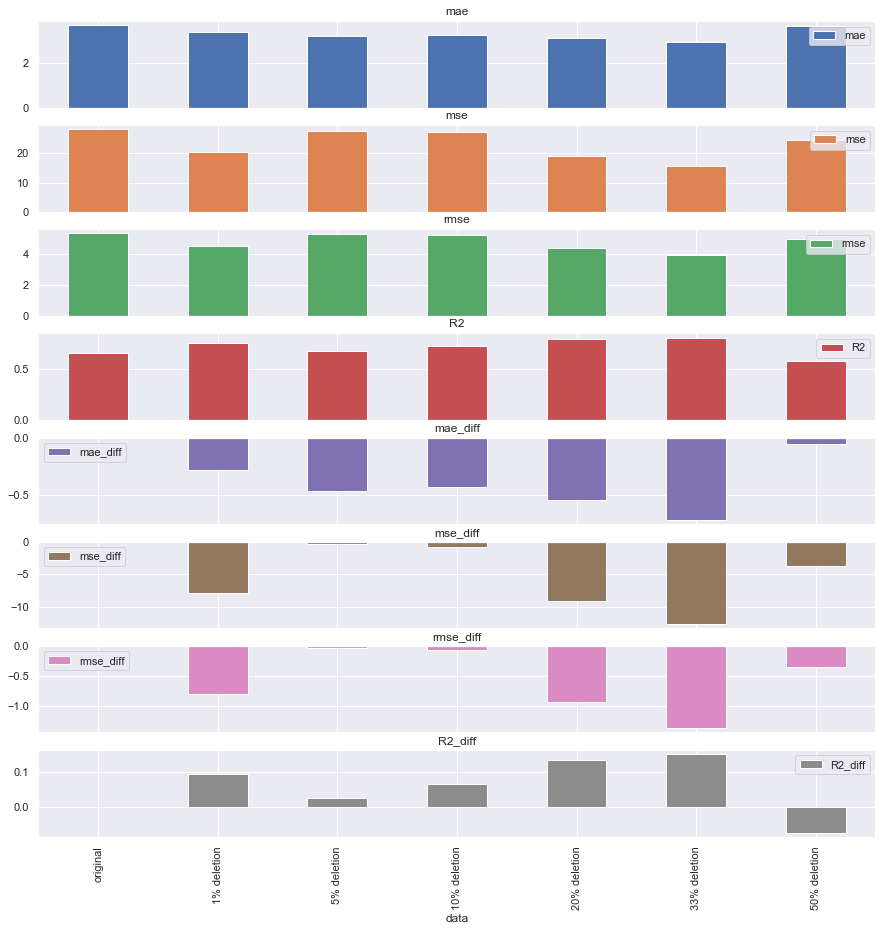

In [18]:
res_frame.plot.bar(x='data', subplots=True, figsize=(15,15))

In [19]:
res_frame

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.660153,28.192486,5.309660,0.659247,NaN,NaN,NaN,NaN
1,1% deletion,MCAR,3.380100,20.406120,4.517313,0.755851,-0.280052,-7.786365,-0.792346,0.096604
2,5% deletion,MCAR,3.190474,27.808308,5.273358,0.685634,-0.469679,-0.384178,-0.036301,0.026387
3,10% deletion,MCAR,3.227581,27.418913,5.236307,0.726436,-0.432572,-0.773573,-0.073352,0.067189
4,20% deletion,MCAR,3.112742,19.153151,4.376431,0.794744,-0.547410,-9.039335,-0.933228,0.135498
5,33% deletion,MCAR,2.940917,15.563245,3.945028,0.813610,-0.719236,-12.629240,-1.364632,0.154363
6,50% deletion,MCAR,3.607327,24.514905,4.951253,0.583272,-0.052825,-3.677581,-0.358407,-0.075975


Through our deletion procedure, we found that our best performing deletion percentage was 33%, which was surprizing as we would assume the more variables available for deletion would lead to a stronger model. However, there's a possibility there was a threshold were the deletion caused an overfit which hampered performance. 

Next we will try an imputation procedure to see how that performs in comparison.

## Imputation

The next approach to dealing with values missing at random is imputation. We chose mean imputation and again generated 6 new datasets with missing values. Like the full set, the new sets were split into training and testing sets then fitted to a linear regression.

In [20]:
insert_na(.50,"RM")
bos_na50 = bos_na
bos_na50.name = "50% Imputed"
insert_na(.33,"RM")
bos_na33 = bos_na
bos_na33.name = "33% Imputed"
insert_na(.20,"RM")
bos_na20 = bos_na
bos_na20.name = "20% Imputed"
insert_na(.10,"RM")
bos_na10 = bos_na
bos_na10.name = "10% Imputed"
insert_na(.05,"RM")
bos_na05 = bos_na
bos_na05.name = "5% Imputed"
insert_na(.01,"RM")
bos_na01 = bos_na
bos_na01.name = "1% Imputed"

Null values at 0.50 : 253
Null values at 0.33 : 167
Null values at 0.20 : 101
Null values at 0.10 : 51
Null values at 0.05 : 25
Null values at 0.01 : 5


Here, we can see the number of observations in the test set we will be looking to impute with our models. 

### Missing Data Completely at Random

Now that we have our imputation variables, we will run the same linear regression procedure that was used during the deletion phase using the same percentages. We will be using "PRICE" as our explanatory variable, which will be the same as we would do with the deletion.

In [21]:
frames = [bos_na01, bos_na05, bos_na10, bos_na20, bos_na33, bos_na50]

for frame in frames:
    df = frame

    # impute nan values with mean
    df = df.apply(lambda x: x.fillna(x.mean()),axis=0)

    X_b = np.c_[np.ones((len(df[features]),1)), df[features].values] 
    X_b.shape

    X = df.drop('PRICE', axis = 1)
    Y = df['PRICE']

    X_train, X_test, Y_train, Y_test = train_test_split(X_b, Y, test_size = 0.20, random_state = 123)

    reg = LinearRegression(normalize=True).fit(X_train, Y_train)

    Y_pred = reg.predict(X_test)

    mae = mean_absolute_error(Y_test,Y_pred)
    mse = mean_squared_error(Y_test,Y_pred)
    rmse_val = rmse(Y_test,Y_pred)
    r2 = r2_score(Y_test,Y_pred)
    print('=======================')
    print(str(frame.name))
    print("MAE: %.3f"%mae)
    print("MSE:  %.3f"%mse)
    print("RMSE:  %.3f"%rmse_val)
    print("R2:  %.3f"%r2)
    print('=======================')
    
    temp_frame = pd.DataFrame({'data':frame.name,
                   'imputation':'MCAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[7])

    res_frame = pd.concat([res_frame, temp_frame])
    res_frame.reset_index(inplace=True)
    res_frame = res_frame.drop('index', axis=1)

1% Imputed
MAE: 3.729
MSE:  30.147
RMSE:  5.491
R2:  0.706
5% Imputed
MAE: 3.353
MSE:  27.802
RMSE:  5.273
R2:  0.636
10% Imputed
MAE: 3.874
MSE:  31.168
RMSE:  5.583
R2:  0.697
20% Imputed
MAE: 3.338
MSE:  18.125
RMSE:  4.257
R2:  0.682
33% Imputed
MAE: 3.744
MSE:  22.958
RMSE:  4.791
R2:  0.735
50% Imputed
MAE: 3.923
MSE:  30.818
RMSE:  5.551
R2:  0.606


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2737f510>,
      dtype=object)

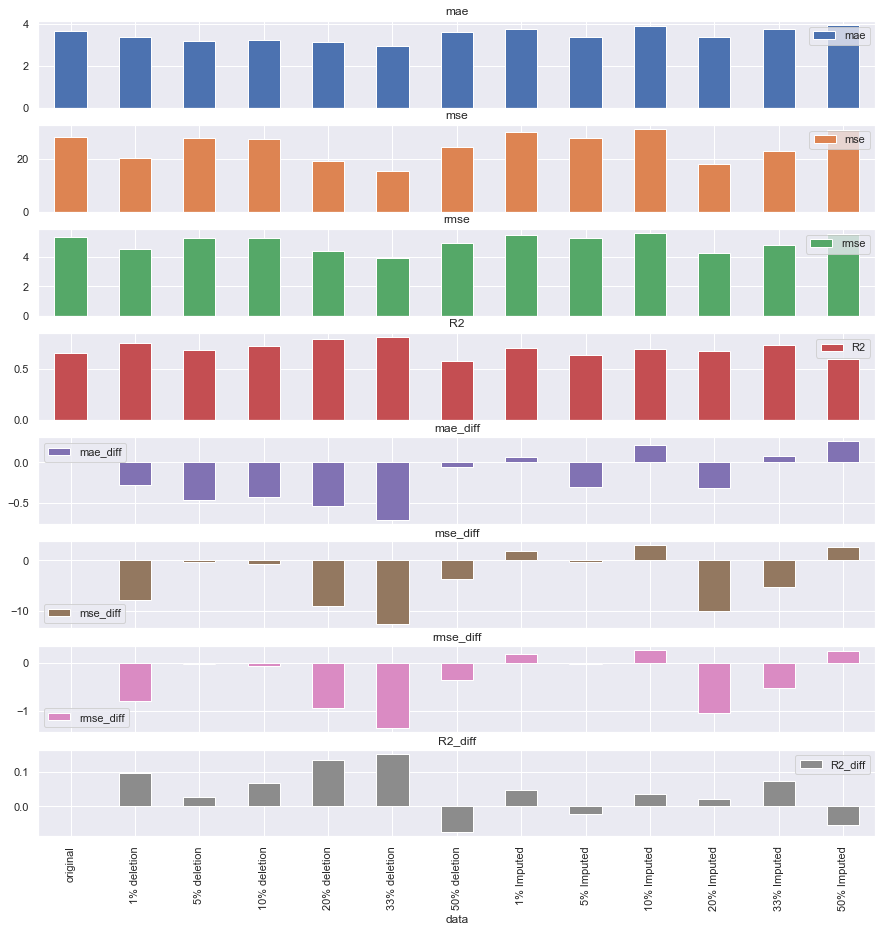

In [22]:
res_frame.plot.bar(x='data', subplots=True, figsize=(15,15))

In [23]:
res_frame

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.660153,28.192486,5.309660,0.659247,NaN,NaN,NaN,NaN
1,1% deletion,MCAR,3.380100,20.406120,4.517313,0.755851,-0.280052,-7.786365,-0.792346,0.096604
2,5% deletion,MCAR,3.190474,27.808308,5.273358,0.685634,-0.469679,-0.384178,-0.036301,0.026387
3,10% deletion,MCAR,3.227581,27.418913,5.236307,0.726436,-0.432572,-0.773573,-0.073352,0.067189
4,20% deletion,MCAR,3.112742,19.153151,4.376431,0.794744,-0.547410,-9.039335,-0.933228,0.135498
5,33% deletion,MCAR,2.940917,15.563245,3.945028,0.813610,-0.719236,-12.629240,-1.364632,0.154363
6,50% deletion,MCAR,3.607327,24.514905,4.951253,0.583272,-0.052825,-3.677581,-0.358407,-0.075975
7,1% Imputed,MCAR,3.728962,30.146872,5.490617,0.706390,0.068810,1.954386,0.180957,0.047144
8,5% Imputed,MCAR,3.353372,27.801646,5.272727,0.636389,-0.306781,-0.390840,-0.036933,-0.022858
9,10% Imputed,MCAR,3.874012,31.167590,5.582794,0.696815,0.213859,2.975104,0.273134,0.037568


Overall, it appears that the deletion procedure performed a bit better than our imputation procedure, particularly when we have more data to work with (there wasn't much of a difference when we started with a low percentage of data). 

Compared to the baseline, we found a similar theme that the 50% was not the strongest performing percentage, with 20% and 33% being the best compared to the baseline. 

# Missing at Random (MAR)

In [24]:
bos = bos_df

For this section, we will be applying a conditional statement to a variable in our dataset and, based on that condition, impute 10%, 20% and 30% of the variables for another dataset. 

For this particular case, we will use AGE < 77 as our "z" variable as our conditional statement, and our imputed columns will be "RM" and "NOX". As per the problem parameters we will be randomly imputing the median values for the missing variables across the two columns. 

In [25]:
# Create training and testing sets (cross-validation not needed)
train_set = bos.sample(frac=0.8, random_state=100)
test_set = bos[~bos.isin(train_set)].dropna()
print(train_set.shape[0])
print(test_set.shape[0])

405
101


In [26]:
bos['AGE'].describe()    

count    506.000000
mean      68.574901
std       28.148861
min        2.900000
25%       45.025000
50%       77.500000
75%       94.075000
max      100.000000
Name: AGE, dtype: float64

In [27]:
def imputeValuesQ3(imputePercent):
    if 77 > bos['AGE'].all():   #this sets the conditional.  Note the use of "series.all()".  Need to apply that for order of ops in numpy.
        in_sample = bos.sample(frac=imputePercent, random_state=99)
        in_sample.shape
        out_sample = bos[~bos.isin(in_sample)].dropna()
        out_sample.shape
        print(out_sample.shape[0] + in_sample.shape[0])
        print(bos.shape[0])
        in_sample.head()
        in_sample['RM'] = np.nan
        in_sample['NOX'] = np.nan  #this is the second selected variable for application of the random application of NaN
        in_sample.head()
        out_sample['RM'].median()
        out_sample['NOX'].median()
        in_sample['RM'] = in_sample['RM'].fillna(out_sample['RM'].median())
        in_sample['NOX'] = in_sample['NOX'].fillna(out_sample['NOX'].median())
        in_sample.head()
        imputed_data = pd.concat([in_sample, out_sample])
        imputed_data = imputed_data.sort_index()
        imputed_data.head()
        train_set = imputed_data.iloc[train_index]
        test_set = imputed_data.iloc[test_index]
        train_set.head()
        X_train = train_set.iloc[:, :-1].values
        Y_train = train_set.iloc[:, -1].values
        X_test = test_set.iloc[:, :-1].values
        Y_test = test_set.iloc[:, -1].values
        reg2 = LinearRegression().fit(X_train, Y_train)
        print(reg2.score(X_train, Y_train))
        print(reg2.coef_)
        print(reg2.intercept_)
        print(reg2.get_params())
        Y_pred = reg2.predict(X_test)
        
        mae = mean_absolute_error(Y_test,Y_pred)
        mse = mean_squared_error(Y_test,Y_pred)
        rmse_val = sqrt(mean_squared_error(Y_test,Y_pred))
        r2 = r2_score(Y_test,Y_pred)
        print("MAE: %.3f"%mae)
        print("MSE:  %.3f"%mse)
        print("RMSE:  %.3f"%rmse_val)
        print("R2:  %.3f"%r2)
    
        temp_data_frame = pd.DataFrame({'data': str(imputePercent*100) + '% imputed',
                   'imputation':'MAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])
    
        print(temp_data_frame)
        return temp_data_frame
    
    else:
        pass    #this sets the false to, effectively, "do nothing"

In the code above, we are creating our data frames based on the 10, 20, 30% imputation rules and below we are swapping the imputed values based on the medians.  

In [28]:
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)

In [29]:

tenPercentImputeq3 = imputeValuesQ3(.10)
twentyPercentImputeq3 = imputeValuesQ3(.20)
thirtyPercentImputeq3 = imputeValuesQ3(.30)

506
506
0.7362241343228925
[-1.25531399e-01  5.37413608e-02  2.55089870e-02  2.75357772e+00
 -9.01238464e+00  4.53597264e+00 -1.44355806e-02 -1.38117018e+00
  2.57596781e-01 -1.14635129e-02 -7.67448857e-01  5.92785045e-03
 -5.83389669e-01]
26.166891215384958
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.913
MSE:  28.451
RMSE:  5.334
R2:  0.672
            data imputation       mae        mse      rmse        R2  \
0  10.0% imputed        MAR  3.913479  28.450974  5.333945  0.672372   

   mae_diff  mse_diff  rmse_diff   R2_diff  
0  0.253326  0.258488   0.024286  0.013126  
506
506
0.7196686654725415
[-1.26388592e-01  6.03985697e-02 -1.20270208e-02  2.53678195e+00
 -6.25322709e+00  4.04083990e+00 -5.68844957e-03 -1.38042705e+00
  2.73860593e-01 -1.20619853e-02 -7.64618178e-01  6.03832216e-03
 -6.61242320e-01]
28.560005935606238
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.745
MSE:  25.538
RMSE:  5.053
R2:  0.706

Below, we included our final output for question 3 to compare against our baseline original model as well as our 12 other imputed/deleted models from question 2 (which we can use as a comparison). Here,we can see that our scored RMSE did not do as well as our previous deletion procedure with our RMSE scores hovering at around 5.

Interestingly, unlike our previous imputations, we did see our RMSE continue to go up without plateauing unlike our other models. 

In [30]:
res_frameq3 = pd.concat([res_frame,tenPercentImputeq3, twentyPercentImputeq3, thirtyPercentImputeq3])
res_frameq3.reset_index(inplace=True)
res_frameq3 = res_frameq3.drop('index', axis=1)
res_frameq3

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.660153,28.192486,5.309660,0.659247,NaN,NaN,NaN,NaN
1,1% deletion,MCAR,3.380100,20.406120,4.517313,0.755851,-0.280052,-7.786365,-0.792346,0.096604
2,5% deletion,MCAR,3.190474,27.808308,5.273358,0.685634,-0.469679,-0.384178,-0.036301,0.026387
3,10% deletion,MCAR,3.227581,27.418913,5.236307,0.726436,-0.432572,-0.773573,-0.073352,0.067189
4,20% deletion,MCAR,3.112742,19.153151,4.376431,0.794744,-0.547410,-9.039335,-0.933228,0.135498
5,33% deletion,MCAR,2.940917,15.563245,3.945028,0.813610,-0.719236,-12.629240,-1.364632,0.154363
6,50% deletion,MCAR,3.607327,24.514905,4.951253,0.583272,-0.052825,-3.677581,-0.358407,-0.075975
7,1% Imputed,MCAR,3.728962,30.146872,5.490617,0.706390,0.068810,1.954386,0.180957,0.047144
8,5% Imputed,MCAR,3.353372,27.801646,5.272727,0.636389,-0.306781,-0.390840,-0.036933,-0.022858
9,10% Imputed,MCAR,3.874012,31.167590,5.582794,0.696815,0.213859,2.975104,0.273134,0.037568


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c279ce710>,
      dtype=object)

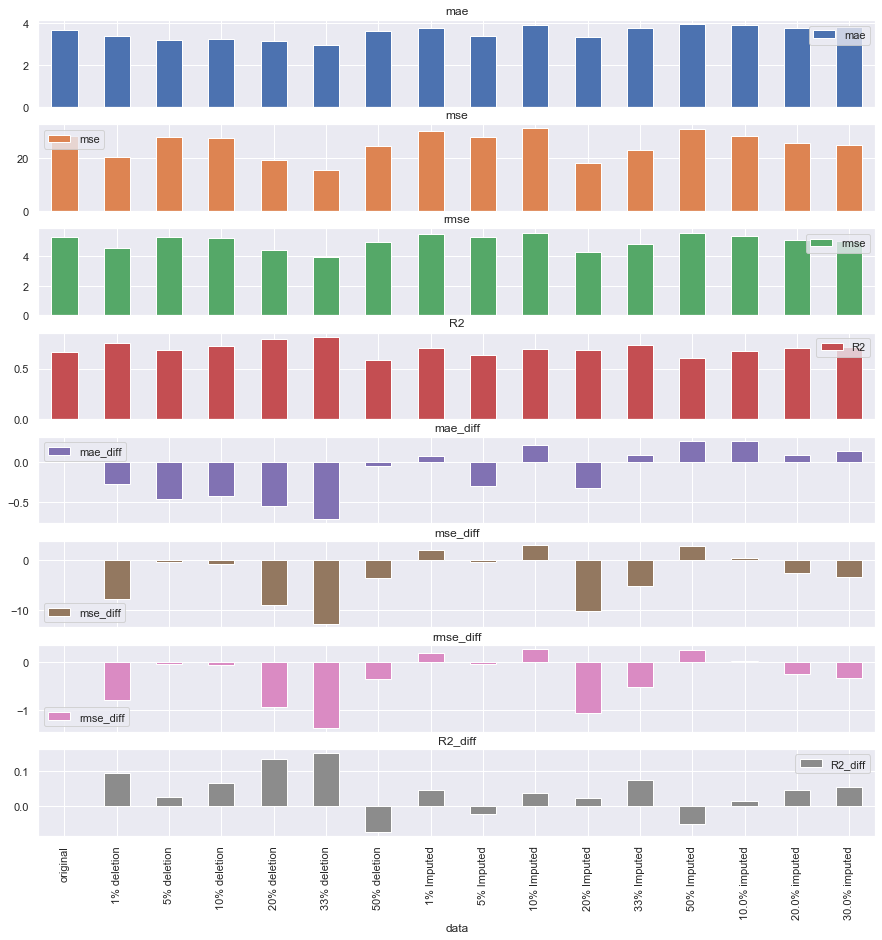

In [31]:
res_frameq3.plot.bar(x='data', subplots=True, figsize=(15,15))

In [32]:
bos.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


There could be some collinearity at play, since Age and Nox were correlated in our baseline data, however, it doesn't seem to be affecting our missing data results.

# Missing Not at Random

For the Missing Not At Random layout, we will be creating a missing at random pattern in which 25% of the data will be missing for a single column. From here, we will impute the data and compare the results to the baseline. 

For this, we will remove 25% of the "RM" variable's observations, and impute the existing values with the medium for the column. 

In [33]:
dfImputeQ4 = bos_df
rmMedian = dfImputeQ4['RM'].median()

dfImputeQ4['RM'][0:125] = np.nan
dfImputeQ4['RM'].fillna(rmMedian, inplace=True)  

imputed_data1 = dfImputeQ4      
train_set = imputed_data1.iloc[train_index]
test_set = imputed_data1.iloc[test_index]        
X_train = train_set.iloc[:, :-1].values
Y_train = train_set.iloc[:, -1].values
X_test = test_set.iloc[:, :-1].values
Y_test = test_set.iloc[:, -1].values
reg2 = LinearRegression().fit(X_train, Y_train)

print(reg2.score(X_train, Y_train))
print(reg2.coef_)
print(reg2.intercept_)
print(reg2.get_params())

Y_pred = reg2.predict(X_test)
mae = mean_absolute_error(Y_test,Y_pred)
mse = mean_squared_error(Y_test,Y_pred)
rmse_val = sqrt(mean_squared_error(Y_test,Y_pred))
r2 = r2_score(Y_test,Y_pred)
print("MAE: %.3f"%mae)
print("MSE:  %.3f"%mse)
print("RMSE:  %.3f"%rmse_val)
print("R2:  %.3f"%r2)
    
Q4_data_frame = pd.DataFrame({'data': '-25% imputed',   #here is the new df containing the loss & goodness of fit metrics
                   'imputation':'MNAR',
                   'mae': mae, 
                   'mse': mse, 
                   'rmse':rmse_val,
                   'R2':r2,
                   'mae_diff':mae-orig_mae,
                   'mse_diff':mse-orig_mse,
                   'rmse_diff':rmse_val-orig_rmse_val,
                   'R2_diff':r2-orig_r2
                   }, index=[0])

0.7315847494239631
[-1.23952815e-01  5.47361057e-02  3.16732970e-02  2.92303253e+00
 -1.69286634e+01  4.02706259e+00 -5.35776825e-03 -1.56157712e+00
  2.93111145e-01 -1.02638381e-02 -8.93890453e-01  7.03543537e-03
 -5.84753049e-01]
34.90777250632957
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
MAE: 3.761
MSE:  25.987
RMSE:  5.098
R2:  0.701


Here, we can see the loss of goodness of fit metrics with our output for Q4, along with the previous 15 models that we ran previously. 

In [34]:
res_frameq4 = pd.concat([res_frameq3,Q4_data_frame])
res_frameq4.reset_index(inplace=True)
res_frameq4 = res_frameq4.drop('index', axis=1)
res_frameq4

,data,imputation,mae,mse,rmse,R2,mae_diff,mse_diff,rmse_diff,R2_diff
0,original,none,3.660153,28.192486,5.309660,0.659247,NaN,NaN,NaN,NaN
1,1% deletion,MCAR,3.380100,20.406120,4.517313,0.755851,-0.280052,-7.786365,-0.792346,0.096604
2,5% deletion,MCAR,3.190474,27.808308,5.273358,0.685634,-0.469679,-0.384178,-0.036301,0.026387
3,10% deletion,MCAR,3.227581,27.418913,5.236307,0.726436,-0.432572,-0.773573,-0.073352,0.067189
4,20% deletion,MCAR,3.112742,19.153151,4.376431,0.794744,-0.547410,-9.039335,-0.933228,0.135498
5,33% deletion,MCAR,2.940917,15.563245,3.945028,0.813610,-0.719236,-12.629240,-1.364632,0.154363
6,50% deletion,MCAR,3.607327,24.514905,4.951253,0.583272,-0.052825,-3.677581,-0.358407,-0.075975
7,1% Imputed,MCAR,3.728962,30.146872,5.490617,0.706390,0.068810,1.954386,0.180957,0.047144
8,5% Imputed,MCAR,3.353372,27.801646,5.272727,0.636389,-0.306781,-0.390840,-0.036933,-0.022858
9,10% Imputed,MCAR,3.874012,31.167590,5.582794,0.696815,0.213859,2.975104,0.273134,0.037568


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c28209b10>,
      dtype=object)

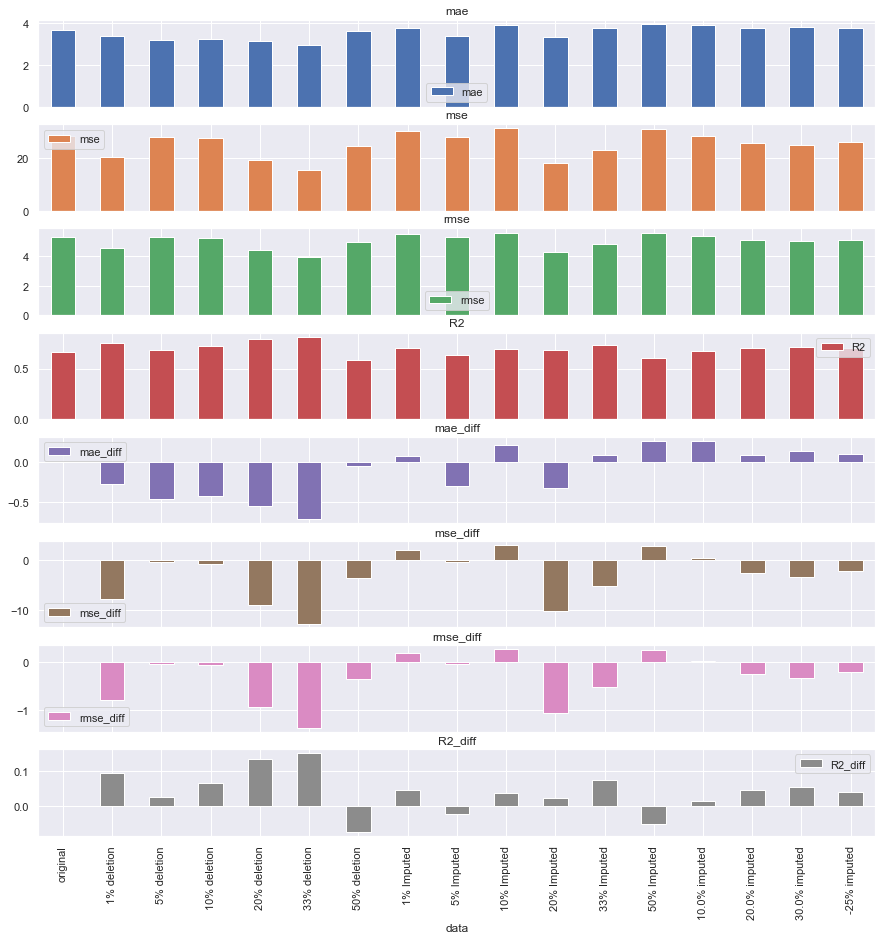

In [35]:
res_frameq4.plot.bar(x='data', subplots=True, figsize=(15,15))

After our Not at Random imputation procedure, we only performed marginally better than our baseline and worse than most of our imputation procedures at much lower percentages. For example, our RMSE was 5.09 and our original was 5.30 (the lower score being the more accurate). 

The reason why we think this is the case and also generally worse than our Missing at Random previous is due to the bias introduced by our method of imputation that was not random. In doing so, it cut out a portion of data that informed our median value which moved our median value away from what it should have been. 

In [36]:
def normal_equation(x,y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T, x)), x.T),y)

theta = normal_equation(X_train, Y_train)
theta

array([-1.12115128e-01,  5.93431306e-02,  1.28921943e-03,  3.23468026e+00,
       -2.77027849e+00,  6.10298697e+00, -1.13848128e-02, -1.11506251e+00,
        1.61564291e-01, -6.86838398e-03, -3.42552258e-01,  1.16658203e-02,
       -5.06999638e-01])

In [37]:
pred = np.dot(X_train, theta)

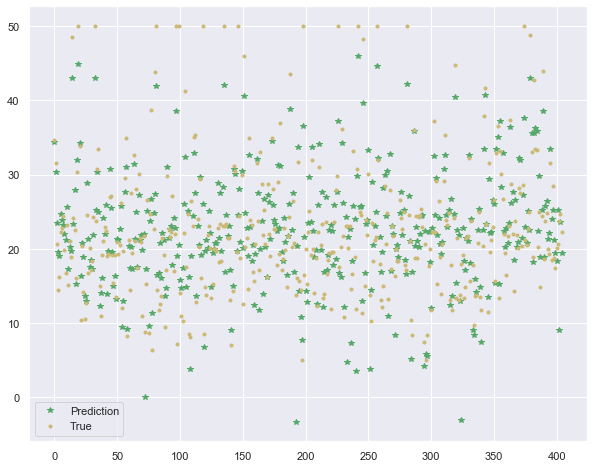

In [38]:
ax, fig = plt.subplots(figsize = (10,8))
plt.plot(pred, 'g.', marker = '*')
plt.plot(Y_train, 'y.')
plt.legend(['Prediction', 'True'])
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
mse_train = sklearn.metrics.mean_squared_error(pred, Y_train)
print(mse_train)

24.539759703846


In [40]:
test_pred = np.dot(X_test, theta)

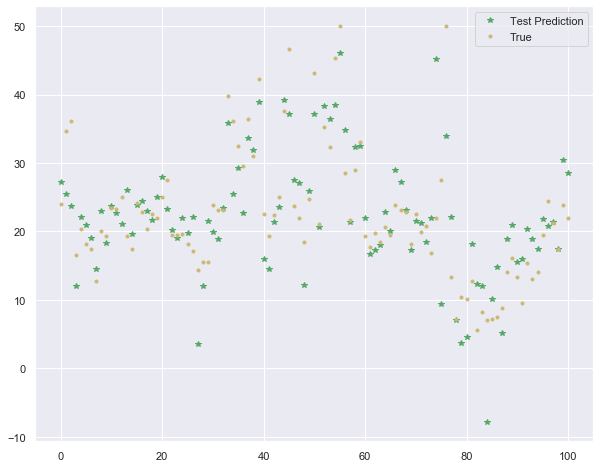

In [41]:
ax, fig = plt.subplots(figsize = (10,8))
plt.plot(test_pred, 'g.', marker = '*')
plt.plot(Y_test, 'y.')
plt.legend(['Test Prediction', 'True'])
plt.show()

In [42]:
mse_test = sklearn.metrics.mean_squared_error(test_pred, Y_test)
print(mse_test)

32.73434535881713


In [43]:
lm = LinearRegression()
lm.fit(X_train, Y_train)

Y_pred = lm.predict(X_test)

In [44]:
mse = sklearn.metrics.mean_squared_error(Y_test, Y_pred)
print(mse)

25.98661577731653


# Conclusion

In total, we presented 15 different imputation procedures as points of comparison to our original baselines. While each imputation had a unique response against our key performance indicators (MAE, MSE, RMSE, and R^2), we saw that we seemed to see diminishing returns whenever we work towards a higher percentage of imputation data. In general, our sweet spot was roughly a 30% - 33% imputation which generated the strongest performing imputation procedure, with our residuals increasing at the 50% level. 

The reason we believe this is the case is due to the bias that is created when you are missing a significant piece of data (whether they are missing at random, completely random or not at random).With a percentage too large, we are likely throwing off the training data median from the actual median which is ultimately giving us an incorrect prediction. The 30% level seems to be the sweet spot between over biasing our imputation and under-representing our training data. 

With regards to our approaches towards imputation, our strongest performing model was the missing completely random imputation procedure using the dropna() function (deletion) to drop observations with missing values. While the lower available variables led to poorer performance our overall best-performing score was deletion with 33% of the variables available.

# Deployment

Missing data can occure for multiple reasons and from multiple sources. This can be an incomplete data collection process, data entry errors, or a missing value in any of database attributes. The important thing is that such missing values can be handled programmatically through right and most commonly used machine learning algorithms. 

Missing data can be viwed as a problem or a possiblity and can be interpret using machine learning methods such as automatic imputation which is necessary for accurate estimate of the statistical analysis. 

However during deployment for a model that is trained on a training set must not implicitly assume that both sets are drawn from the same distribution and therfore must be deployed on test data the similar way by pre-processing missing data.  

You must not use your target variable when imputing on the training data. 
